In [33]:
%pip install opencv-python tensorflow pillow scikit-learn matplotlib 'tensorflow[and-cuda]'

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from PIL import Image
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras import metrics
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K


Note: you may need to restart the kernel to use updated packages.


In [34]:
import tensorflow as tf

# Limitar a quantidade de memória da GPU usada
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memória da GPU configurada para crescimento")
    except RuntimeError as e:
        print(e)

# Verifique o uso da GPU
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

Memória da GPU configurada para crescimento
GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:

# Caminhos
data_dir = './faces'  # Pasta com os dados de treino
output_dir = './faces_detectadas'
batch_size = 32

# Parâmetros
img_width, img_height = 150, 150
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Cria o diretório de saída se não existir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Inicializa contador de imagem
img_counter = 0


In [172]:
# Varre cada subpasta dentro do diretório de dados
for person_name in os.listdir(data_dir):
    person_path = os.path.join(data_dir, person_name)

    # Verifica se é um diretório (representando uma classe)
    if os.path.isdir(person_path):
        # Cria uma subpasta para a classe no diretório de saída
        class_output_dir = os.path.join(output_dir, person_name)
        os.makedirs(class_output_dir, exist_ok=True)

        # Itera sobre cada imagem na subpasta da classe
        for img_name in os.listdir(person_path):
            img_path = os.path.join(person_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Converte a imagem para escala de cinza
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Detecta faces na imagem
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

                # Para cada face detectada, recorta e salva a imagem
                for (x, y, w, h) in faces:
                    face_img = img[y:y+h, x:x+w]
                    resized_face = cv2.resize(face_img, (img_width, img_height))

                    # Define o nome do arquivo de saída
                    output_filename = f'img{img_counter}.jpg'
                    output_path = os.path.join(class_output_dir, output_filename)

                    # Salva a face detectada
                    cv2.imwrite(output_path, resized_face)
                    print(f'Face detectada salva em: {output_path}')

                    # Incrementa o contador de imagens
                    img_counter += 1
            else:
                print(f'Erro ao carregar imagem: {img_path}')

Face detectada salva em: ./faces_detectadas/Araujo/img151.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img152.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img153.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img154.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img155.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img156.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img157.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img158.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img159.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img160.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img161.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img162.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img163.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img164.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img165.jpg
Face detectada salva em: ./faces_detectadas/Araujo/img166.jpg
Face det

In [36]:
# Atualiza o diretório de dados para as faces detectadas
data_dir_faces = './faces_detectadas'

# Data augmentation e preparação do gerador de dados de treino para as faces detectadas
datagen_faces = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator_faces = datagen_faces.flow_from_directory(
    data_dir_faces,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator_faces = datagen_faces.flow_from_directory(
    data_dir_faces,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Impressão de informações do gerador
print("Classes detectadas: ", train_generator_faces.class_indices)
print("Número de imagens de treinamento: ", train_generator_faces.samples)
print("Número de imagens de validação: ", validation_generator_faces.samples)

Found 195 images belonging to 6 classes.
Found 46 images belonging to 6 classes.
Classes detectadas:  {'Araujo': 0, 'Bodruch': 1, 'Giovanelli': 2, 'Nery': 3, 'Thiago': 4, 'Vinicin': 5}
Número de imagens de treinamento:  195
Número de imagens de validação:  46


In [37]:
# Caminhos e Parâmetros
data_dir = './faces_detectadas'
img_width, img_height = 150, 150

# Carregar e organizar os dados manualmente
images = []
labels = []
# Itera por cada subpasta que representa uma classe
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_path):  # Verifica se é uma pasta
        for filename in os.listdir(class_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                # Carrega a imagem e redimensiona
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path)

                if img is not None:  # Verifica se a imagem foi carregada com sucesso
                    img = cv2.resize(img, (img_width, img_height))
                    
                    # Normaliza a imagem
                    img = img / 255.0
                    images.append(img)
                    labels.append(class_name)  # Usa o nome da subpasta como rótulo
                else:
                    print(f"Erro ao carregar a imagem: {img_path}")

# Verifica se existem imagens e rótulos antes de prosseguir
if not images or not labels:
    raise ValueError("Nenhuma imagem ou rótulo foi processado. Verifique o diretório de dados e o formato dos arquivos.")

# Converte as listas em arrays numpy
images = np.array(images)
labels = np.array(labels)

# Codificação das Labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Verifica se `num_classes` é maior que zero
if num_classes == 0:
    raise ValueError("Nenhuma classe foi detectada.")

labels_categorical = to_categorical(labels_encoded, num_classes)


In [38]:
def custom_recall(y_real, y_pred):
    true_positives = K.sum(K.round(K.clip(y_real * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_real, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def custom_precision(y_real, y_pred):
    true_positives = K.sum(K.round(K.clip(y_real * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def custom_f1(y_real, y_pred):
    precision = custom_precision(y_real, y_pred)
    recall = custom_recall(y_real, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:

# Gerador de dados para aumento de dados

# Definição do Modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])

# Treinamento do Modelo (substitua `validation_generator_faces` pelo seu gerador de validação)
training_history = model.fit(train_generator_faces, epochs=95, validation_data=validation_generator_faces, verbose=1)


/home/vinicius/Documents/Aulas/ProcessamentoImagem/face_detection/face_detection/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/vinicius/Documents/Aulas/ProcessamentoImagem/face_detection/face_detection/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/95


2024-11-13 16:46:25.393851: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads



3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1910 - loss: 1.9195 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

2024-11-13 16:46:28.993015: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.1921 - loss: 1.9097 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

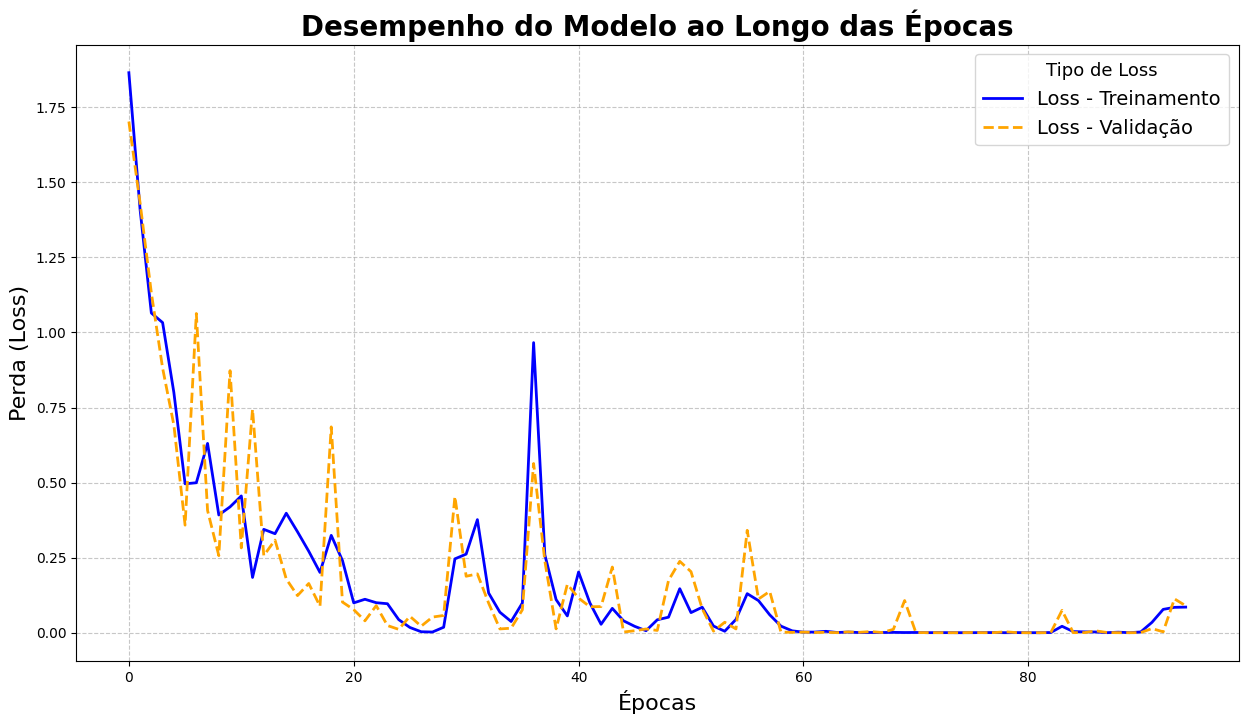

In [ ]:
# Define o tamanho da figura
plt.figure(figsize=(15, 8))

# Plota a perda do treino e da validação com diferentes estilos e cores
plt.plot(training_history.history['loss'], label='Loss - Treinamento', color='blue', linestyle='-', linewidth=2)
plt.plot(training_history.history['val_loss'], label='Loss - Validação', color='orange', linestyle='--', linewidth=2)

# Adiciona título e rótulos com tamanhos maiores
plt.title('Desempenho do Modelo ao Longo das Épocas', fontsize=20, fontweight='bold')
plt.xlabel('Épocas', fontsize=16)
plt.ylabel('Perda (Loss)', fontsize=16)

# Adiciona uma grade leve para melhor leitura
plt.grid(True, linestyle='--', alpha=0.7)

# Formata a legenda e define sua posição
plt.legend(loc='upper right', fontsize=14, title='Tipo de Loss', title_fontsize='13')

# Exibe o gráfico
plt.show()

In [ ]:

# print("Modelo treinado e salvo com sucesso.")
model.save('face_recognition_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


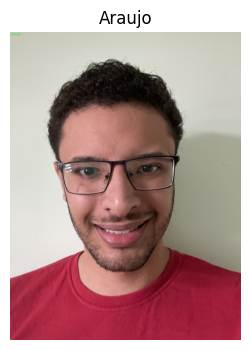

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


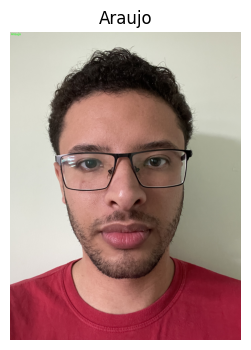

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


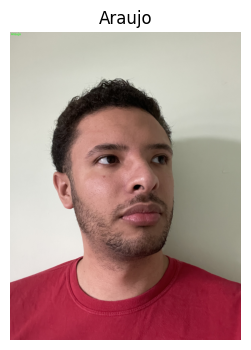

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


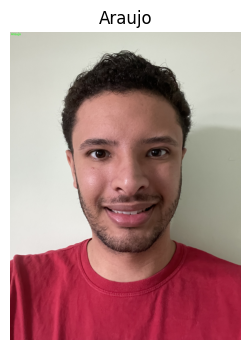

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


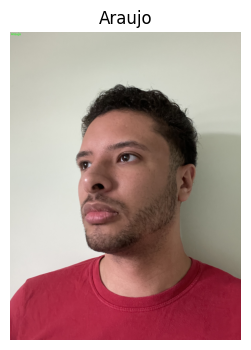

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


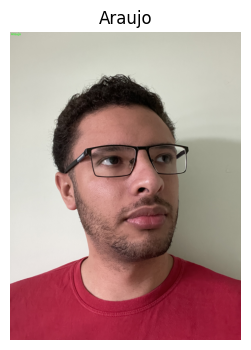

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


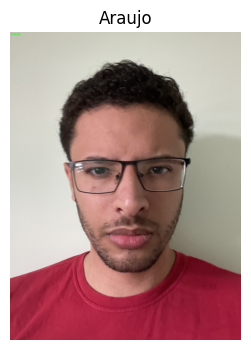

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


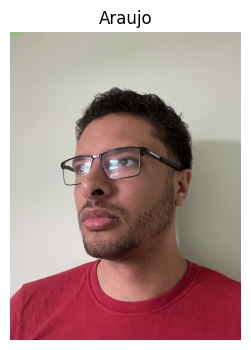

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


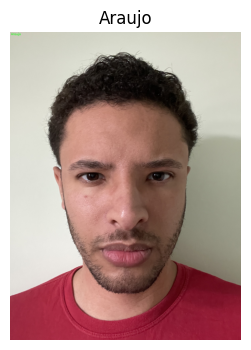

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


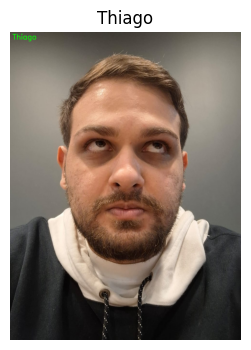

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


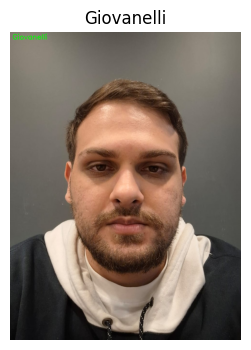

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


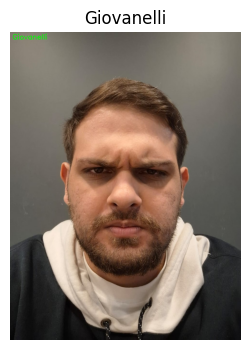

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


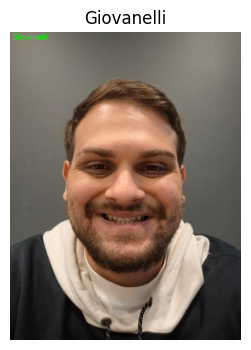

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


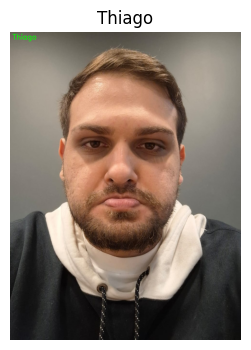

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


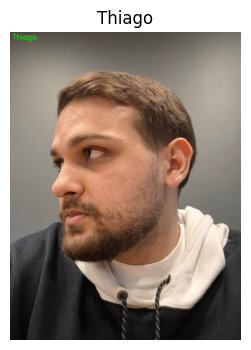

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


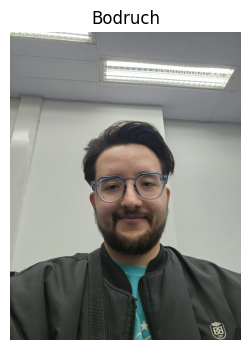

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


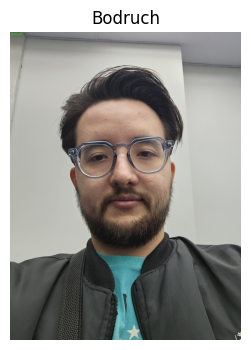

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


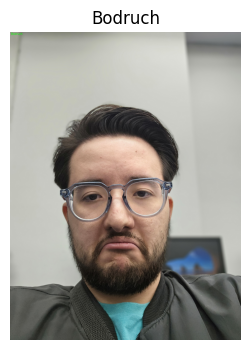

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


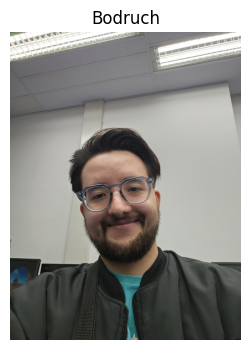

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


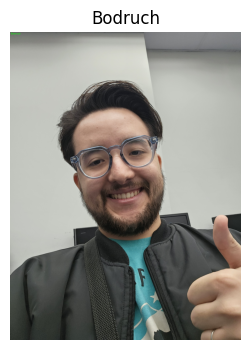

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


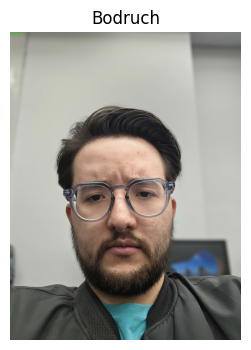

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


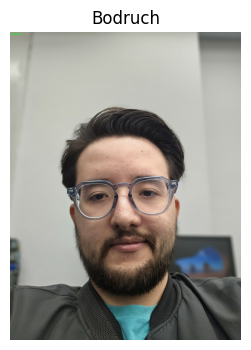

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


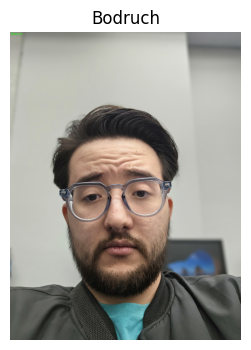

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


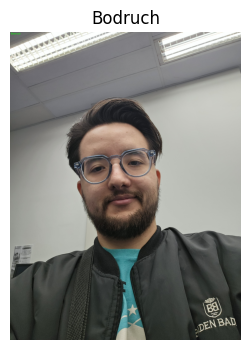

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


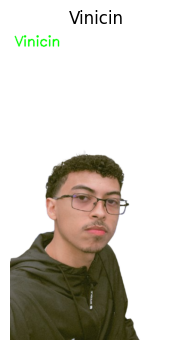

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


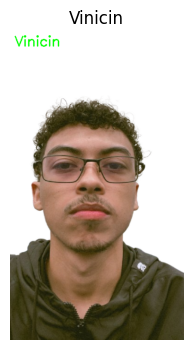

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


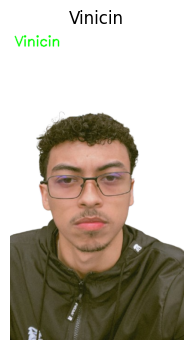

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


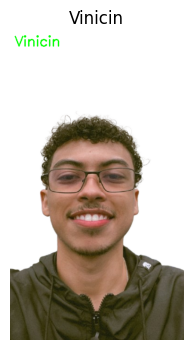

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


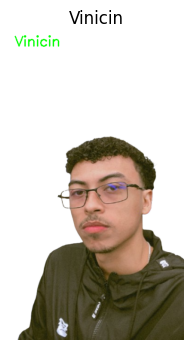

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


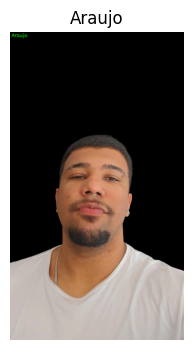

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


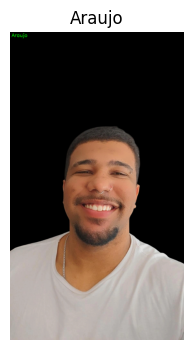

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


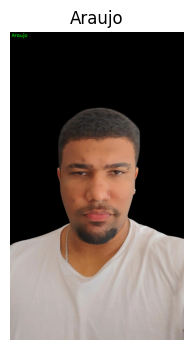

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


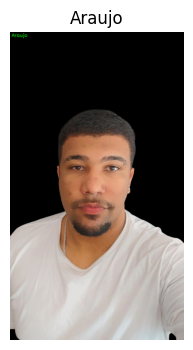

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


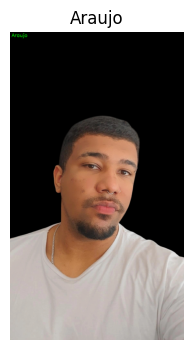

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


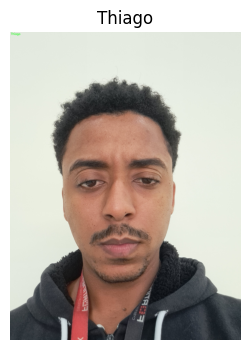

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


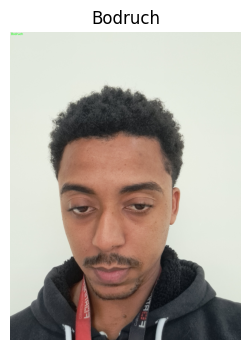

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


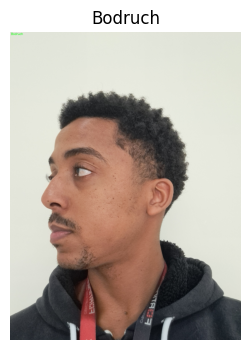

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


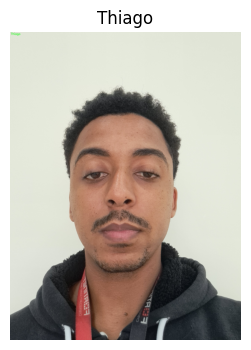

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


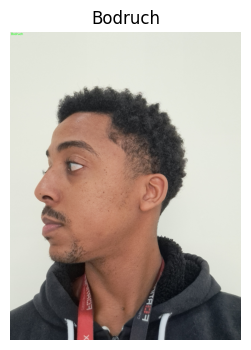

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


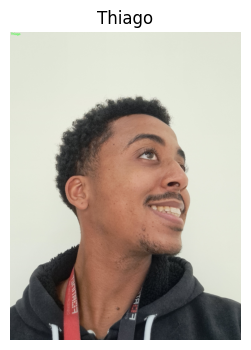

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


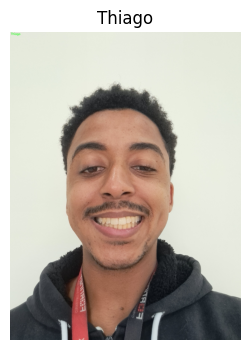

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


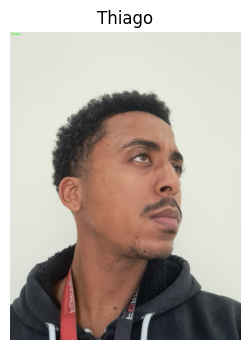

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Caminhos e parâmetros
test_dir = './faces'  # Diretório das imagens de teste
model_path = './face_recognition_model.keras'

# Parâmetros da imagem
img_width, img_height = 150, 150

# Carrega o modelo treinado
model = load_model(model_path)

# Recria o LabelEncoder usado no treinamento
label_encoder = LabelEncoder()
label_encoder.fit([d for d in os.listdir('./faces_detectadas') if os.path.isdir(os.path.join('./faces_detectadas', d))])
num_classes = len(label_encoder.classes_)

# Laço para processar cada subpasta (classe)
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    
    if os.path.isdir(class_path):  # Verifica se é uma pasta
        for filename in os.listdir(class_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                # Caminho completo da imagem
                img_path = os.path.join(class_path, filename)
                
                # Carrega a imagem e redimensiona
                img = cv2.imread(img_path)
                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converte para RGB
                    img_resized = cv2.resize(img_rgb, (img_width, img_height)) / 255.0
                    img_resized = np.expand_dims(img_resized, axis=0)
                    
                    # Realiza a predição
                    prediction = model.predict(img_resized)
                    predicted_class = np.argmax(prediction, axis=1)
                    predicted_label = label_encoder.inverse_transform(predicted_class)[0]

                    # Exibe a imagem com Matplotlib (ajustando o tamanho para exibição)
                    plt.figure(figsize=(4, 4))  # Ajuste o figsize conforme necessário
                    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Converte de volta para RGB para o matplotlib
                    plt.title(predicted_label)
                    plt.axis('off')  # Remove eixos
                    plt.show()
                    cv2.waitKey(900)  # Aguarda por 900ms antes de fechar a imagem
                    cv2.destroyAllWindows()

In [ ]:
custom_f1()

In [168]:
# # Carrega o modelo treinado
# model = load_model('./face_recognition_model.h5')

# # Dicionário de classes
# class_dict = {v: k for k, v in train_generator.class_indices.items()}
# df = cv2.CascadeClassifier('classifier.xml')

# input_dir = './faces/elvis'

# # Processa cada imagem na pasta 'faces'
# for filename in os.listdir(input_dir):
#     if filename.endswith('.jpg'):
#         file_path = os.path.join(input_dir, filename)
#         i = cv2.imread(file_path)
#         iPB = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)

#         # Executa a detecção de faces
#         faces = df.detectMultiScale(iPB, scaleFactor=1.05, minNeighbors=7, minSize=(30,30), flags=cv2.CASCADE_SCALE_IMAGE)

#         # Salva cada face detectada na nova pasta com rótulo
#         for j, (x, y, w, h) in enumerate(faces):
#             face = i[y:y+h, x:x+w]
#             face_resized = cv2.resize(face, (img_width, img_height))
#             face_normalized = face_resized / 255.0
#             face_reshaped = np.reshape(face_normalized, (1, img_width, img_height, 3))
#             prediction = model.predict(face_reshaped)
#             label = class_dict[np.argmax(prediction)]
#             face_filename = os.path.join(output_dir, f'{os.path.splitext(filename)[0]}_{label}_{j}.jpg')
#             cv2.imwrite(face_filename, face)
#             cv2.rectangle(i, (x, y), (x + w, y + h), (0, 255, 255), 7)
#             cv2.putText(i, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

#         # Exibe a imagem com as faces detectadas e rotuladas
#         cv2.imshow(f'{filename} - {len(faces)} face(s) encontrada(s)', i)
#         cv2.waitKey(9900)
#         cv2.destroyAllWindows()
